Trying out sktime for our time series

In [1]:
import math
import pandas as pandas
from pandas import concat
import numpy as np
from scipy.stats import pearsonr
from statistics import mean
from numpy.random import shuffle

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data_248_original = pandas.read_json("../data/device_id_248.json")
data_249_original = pandas.read_json("../data/device_id_249.json")
data_248 = data_248_original.copy()
data_249 = data_249_original.copy()
data_249

,tot1,tot2,analog2
2018-11-23 08:55:00,0.43,0.00,1.11
2018-11-23 08:56:00,0.89,0.00,1.11
2018-11-23 08:57:00,1.38,0.00,1.11
2018-11-23 08:58:00,1.90,0.00,1.11
2018-11-23 08:59:00,2.45,0.00,1.11
...,...,...,...
2020-04-01 08:35:00,797188.56,-293.97,0.82
2020-04-01 08:36:00,797192.50,-293.97,0.81
2020-04-01 08:37:00,797195.06,-293.97,0.81
2020-04-01 08:38:00,797197.62,-293.97,0.81


In [2]:
data_249['day'] = [i.day for i in data_249.index]
data_249['month'] = [i.month for i in data_249.index]
data_249['year'] = [i.year for i in data_249.index]
data_249['hour'] = [i.hour for i in data_249.index]
data_249['minute'] = [i.minute for i in data_249.index]

data_249

,tot1,tot2,analog2,day,month,year,hour,minute
2018-11-23 08:55:00,0.43,0.00,1.11,23,11,2018,8,55
2018-11-23 08:56:00,0.89,0.00,1.11,23,11,2018,8,56
2018-11-23 08:57:00,1.38,0.00,1.11,23,11,2018,8,57
2018-11-23 08:58:00,1.90,0.00,1.11,23,11,2018,8,58
2018-11-23 08:59:00,2.45,0.00,1.11,23,11,2018,8,59
...,...,...,...,...,...,...,...,...
2020-04-01 08:35:00,797188.56,-293.97,0.82,1,4,2020,8,35
2020-04-01 08:36:00,797192.50,-293.97,0.81,1,4,2020,8,36
2020-04-01 08:37:00,797195.06,-293.97,0.81,1,4,2020,8,37
2020-04-01 08:38:00,797197.62,-293.97,0.81,1,4,2020,8,38


## Tranformed time into tabular data

In [3]:
"""
data_249_index = data_249.reset_index()
del data_249_index["index"]
data_249_index""";

In [4]:
data_249_t = data_249.copy()
data_249_t = data_249_t.reset_index()
data_249_t["index"] = data_249_t["index"].dt.floor('h')
data_249_t["index"] = data_249_t["index"].dt.strftime("%Y-%m-%d %H:%M")

data_249_t["index"] = pandas.to_datetime(data_249_t["index"], format="%Y-%m-%d %H:%M")
data_249_t = data_249_t.groupby("index").mean()

data_249_index = data_249_t
data_249_index

,tot1,tot2,analog2,day,month,year,hour,minute
index,,,,,,,,
2018-11-23 08:00:00,1.410000,0.00,1.110000,23.0,11.0,2018.0,8.0,57.0
2018-11-23 09:00:00,26.331167,0.00,1.105000,23.0,11.0,2018.0,9.0,29.5
2018-11-23 10:00:00,94.006333,0.00,1.098500,23.0,11.0,2018.0,10.0,29.5
2018-11-23 11:00:00,182.008000,0.00,1.101000,23.0,11.0,2018.0,11.0,29.5
2018-11-23 12:00:00,278.252500,0.00,0.960333,23.0,11.0,2018.0,12.0,29.5
...,...,...,...,...,...,...,...,...
2020-04-01 04:00:00,796739.947500,-293.97,0.826000,1.0,4.0,2020.0,4.0,29.5
2020-04-01 05:00:00,796816.443333,-293.97,0.824667,1.0,4.0,2020.0,5.0,29.5
2020-04-01 06:00:00,796915.016000,-293.97,0.817167,1.0,4.0,2020.0,6.0,29.5


In [5]:
"""shifting 
data_249_index["shift_analog2"] = data_249_index["analog2"].shift(1)
data_249_index= data_249_index.reindex(["tot1", "tot2", "analog2", 
                                        "shift_analog2", "day", "month", "year", "hour", "minute"],axis=1)
data_249_index.expanding().mean()
np.corrcoef(data_249_index["analog2"], data_249_index["tot1"]) - for correlation
np.corrcoef(data_249_index["analog2"].to_numpy()[1500:], data_249_index["analog2"]
.to_numpy()[:-1500]) """;

"""
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
predicted = lin_reg.predict(X_test)
predicted = lin_reg.predict(X_test)
viz_linear(predicted)""";

## Division to learn and test

In [6]:
def data_sel(start, end, data_fun):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]    
    
data = data_sel("2019-05-23 08:00:00", "2019-06-26 08:00:00", data_249_index).sort_values("year")
#data = data.sort_values("index")
data

,tot1,tot2,analog2,day,month,year,hour,minute
index,,,,,,,,
2019-05-23 08:00:00,235697.895167,-69.99,0.808333,23.0,5.0,2019.0,8.0,29.5
2019-06-14 16:00:00,262036.152167,-277.99,0.803167,14.0,6.0,2019.0,16.0,29.5
2019-06-14 17:00:00,262094.233500,-277.99,0.804000,14.0,6.0,2019.0,17.0,29.5
2019-06-14 18:00:00,262156.033500,-277.99,0.801167,14.0,6.0,2019.0,18.0,29.5
2019-06-14 19:00:00,262230.177500,-277.99,0.802167,14.0,6.0,2019.0,19.0,29.5
...,...,...,...,...,...,...,...,...
2019-06-03 19:00:00,249575.349000,-76.72,0.811667,3.0,6.0,2019.0,19.0,29.5
2019-06-03 20:00:00,249610.299667,-76.72,0.767000,3.0,6.0,2019.0,20.0,29.5
2019-06-03 21:00:00,249632.493167,-76.72,0.768000,3.0,6.0,2019.0,21.0,29.5


In [7]:
matrix_X = data.reset_index().values

"""
# Dividing data on the test and learn set - and not shuffling !!

size_of_learn_set = round(len(matrix_X) * 0.70)
train_set = matrix_X[:size_of_learn_set]
test_set  = matrix_X[size_of_learn_set:]

X_train = train_set[:, 4:]
X_test = test_set[:, 4:]

y_train = train_set[:, 3]
y_test = test_set[:, 3]
"""

# change this train_test splits data randomly
Y_pressure = matrix_X[:, 3]
matrix_X = matrix_X[:, 4:]  
X_train, X_test, y_train, y_test = train_test_split(matrix_X, Y_pressure, test_size=0.3, random_state=0)
X_train[:3]

array([[23.0, 6.0, 2019.0, 17.0, 29.5],
       [24.0, 6.0, 2019.0, 21.0, 29.5],
       [19.0, 6.0, 2019.0, 5.0, 29.5]], dtype=object)

## Polinomial regression

MSE result: 0.0002938814122561071 
MSE balanced by avg value: 0.000371 %
R2 score:  0.36926197068174194


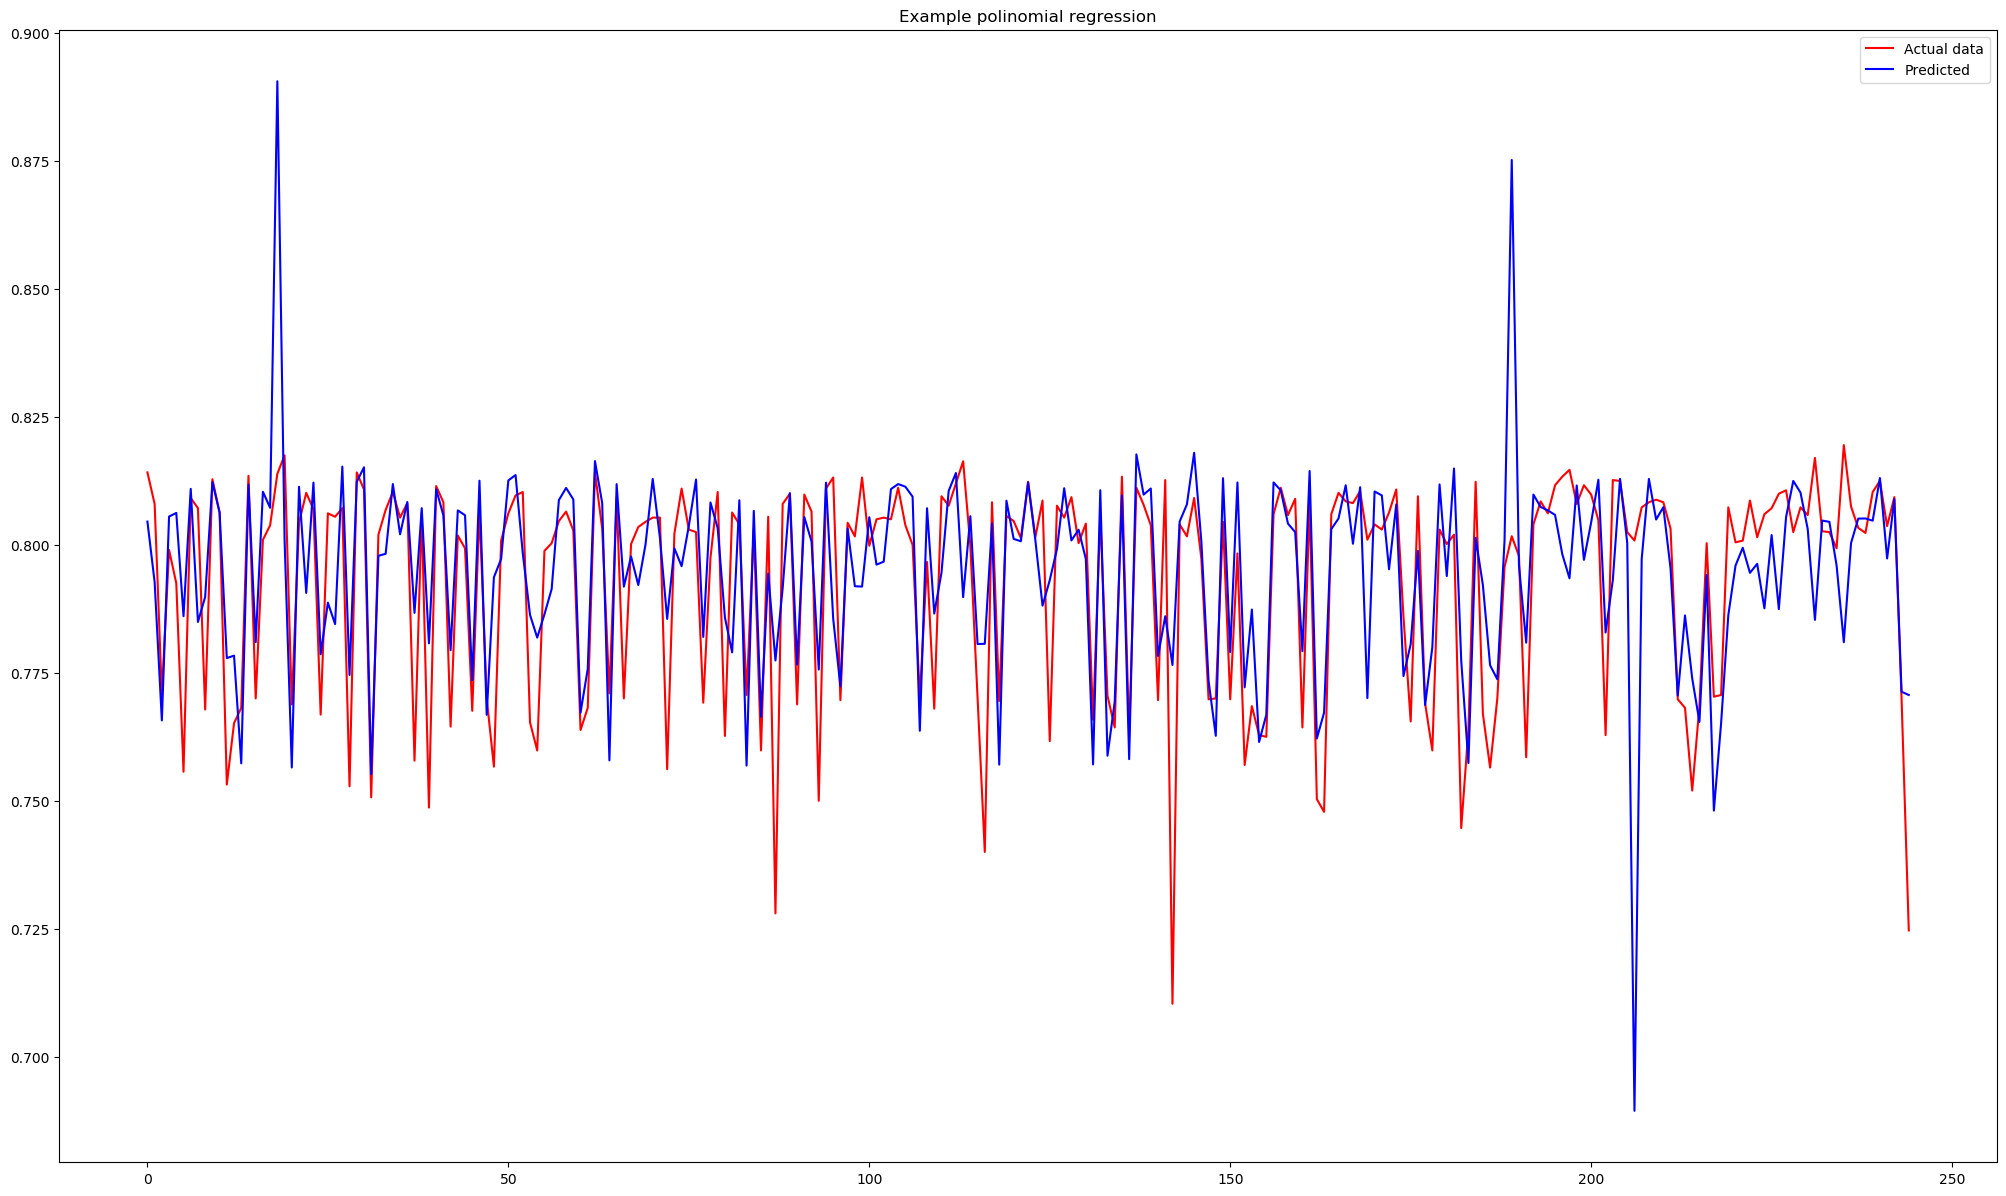

In [8]:
x_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_train)
x_test = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X_test)

model = LinearRegression(fit_intercept=False).fit(x_, y_train)
y_pred = model.predict(x_test)

diff = mean_squared_error(y_test, y_pred)
print("MSE result:", diff, "\nMSE balanced by avg value: {:0.6f}".format((diff / mean(y_test))),"%")

coefficient_of_dermination = r2_score(y_test, y_pred)
print("R2 score: ", coefficient_of_dermination)

plt.figure(figsize=(25, 15), dpi= 100)
plt.plot([i for i in range(len(y_test))], y_test, color='red', label="Actual data")
plt.plot([i for i in range(len(y_pred))], y_pred, color='blue', label="Predicted")
plt.title('Example polinomial regression')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.show()

## Feature Engineering - Lag Features
Trying out lagged features on a 24 hour cycle

In [9]:
data_selected = data_sel("2018-04-23 08:00:00", "2019-08-26 08:00:00", data_249_index).sort_values("year")

data_selected.index.min(), data_selected.index.max(), (data_selected.index.max() -data_selected.index.min())

(Timestamp('2018-11-23 08:00:00'),
 Timestamp('2019-08-26 08:00:00'),
 Timedelta('276 days 00:00:00'))

In [10]:
def generate_learn_test_for_feature():
    data_selected = data_sel("2018-04-23 08:00:00", "2019-08-26 08:00:00", data_249_index).sort_values("year")

    train = data_selected.loc['2018-11-23 08:00:00':'2019-06-23 08:00:00'] 
    test = data_selected.loc['2019-06-23 09:00:00':'2019-08-26 08:00:00']
    print(train.shape, test.shape)
    
    train = train.reset_index()
    del train["index"]
    del train["minute"] # because they are grouped by hour
    del train["tot1"]
    del train["tot2"]
    
    test = test.reset_index()
    del test["index"]
    del test["minute"] # because they are grouped by hour
    del test["tot1"]
    del test["tot2"]
    return train, test

In [11]:
train, test = generate_learn_test_for_feature()
train

(5025, 8) (1533, 8)


,analog2,day,month,year,hour
0,1.110000,23.0,11.0,2018.0,8.0
1,0.832000,18.0,12.0,2018.0,19.0
2,0.837500,18.0,12.0,2018.0,20.0
3,0.775500,18.0,12.0,2018.0,21.0
4,0.771500,18.0,12.0,2018.0,22.0
...,...,...,...,...,...
5020,0.829000,21.0,3.0,2019.0,7.0
5021,0.824333,21.0,3.0,2019.0,6.0
5022,0.823167,21.0,3.0,2019.0,5.0
5023,0.819667,21.0,3.0,2019.0,4.0


In [14]:
def rolling_window_v2(window_width, train, test, plot=True, print_val=True):
    temps = pandas.DataFrame(train["analog2"])
    temps.columns = ["predicted-analog"]

    temps = temps.rolling(window=window_width).mean()
    dataframe = concat([temps, data], axis=1)
    dataframe = dataframe.drop(dataframe.index[[i for i in range(0, window_width)]])
    
    print(dataframe)
    y_val_predicted = dataframe["predicted-analog"].values
    y_val_actual = dataframe["analog2"].values
    
    """print(y_val_predicted)
    print(y_val_actual)
    # i need to train a regresor for learn function
    model = LinearRegression(fit_intercept=False).fit([[i] for i in y_val_actual], y_val_predicted)
    y_pred = model.predict([[i] for i in test["analog2"]])

    if plot:
        fig = plt.figure(figsize=(18, 6), dpi= 100, facecolor='w')
        plt.plot(shared_x, test["analog2"], color="blue", label="Actual")
        plt.plot(shared_x, y_val_predicted, color="red", label="Predicted")

        plt.ylabel('Pressure in bar ?')
        plt.xlabel('Date')
        plt.legend()
        plt.title('Time')
        plt.show()
    
    diff = mean_squared_error(y_val_actual, y_val_predicted)
    coefficient_of_dermination = r2_score(y_val_actual, y_val_predicted)"""
    
    if print_val:
        print("Results for window size -", window_width)
        print("  MSE result: {:0.5f}".format(diff))
        print("  R2 score:   {:0.5f}".format(coefficient_of_dermination))
        
    return coefficient_of_dermination

In [15]:
rolling_window_v2(3, train, test, False)

                     predicted-analog           tot1    tot2   analog2   day  \
3                            0.815000            NaN     NaN       NaN   NaN   
4                            0.794833            NaN     NaN       NaN   NaN   
5                            0.773778            NaN     NaN       NaN   NaN   
6                            0.772889            NaN     NaN       NaN   NaN   
7                            0.772778            NaN     NaN       NaN   NaN   
...                               ...            ...     ...       ...   ...   
2019-06-03 19:00:00               NaN  249575.349000  -76.72  0.811667   3.0   
2019-06-03 20:00:00               NaN  249610.299667  -76.72  0.767000   3.0   
2019-06-03 21:00:00               NaN  249632.493167  -76.72  0.768000   3.0   
2019-06-03 11:00:00               NaN  249129.207000  -76.72  0.812500   3.0   
2019-06-26 08:00:00               NaN  275136.967833 -279.96  0.806667  26.0   

                     month    year  hou

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2192: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return Index.union(this, other, sort=sort).astype(object, copy=False)


0.36926197068174194

In [16]:
def rolling_window(window_width, data, plot=True, print_val=True):
    temps = pandas.DataFrame(data["analog2"])
    temps.columns = ["predicted-analog"]

    temps = temps.rolling(window=window_width).mean()
    # print(temps)
    dataframe = concat([temps, data], axis=1)
    dataframe = dataframe.drop(dataframe.index[[i for i in range(0, window_width - 1)]])
    # print(dataframe.head(5))
    
    y_val_predicted = dataframe["predicted-analog"].values
    y_val_actual = dataframe["analog2"].values
    shared_x = [i for i in range(len(y_val_actual))]
    
    # i need to train a regresor for learn function

    if plot:
        fig = plt.figure(figsize=(18, 6), dpi= 100, facecolor='w')
        plt.plot(shared_x, y_val_actual, color="blue", label="Actual")
        plt.plot(shared_x, y_val_predicted, color="red", label="Predicted")

        plt.ylabel('Pressure in bar ?')
        plt.xlabel('Date')
        plt.legend()
        plt.title('Time')
        plt.show()
    
    diff = mean_squared_error(y_val_actual, y_val_predicted)
    coefficient_of_dermination = r2_score(y_val_actual, y_val_predicted)
    
    if print_val:
        print("Results for window size -", window_width)
        print("  MSE result: {:0.5f}".format(diff))
        print("  R2 score:   {:0.5f}".format(coefficient_of_dermination))
        
    return coefficient_of_dermination

(5025, 8) (1533, 8)


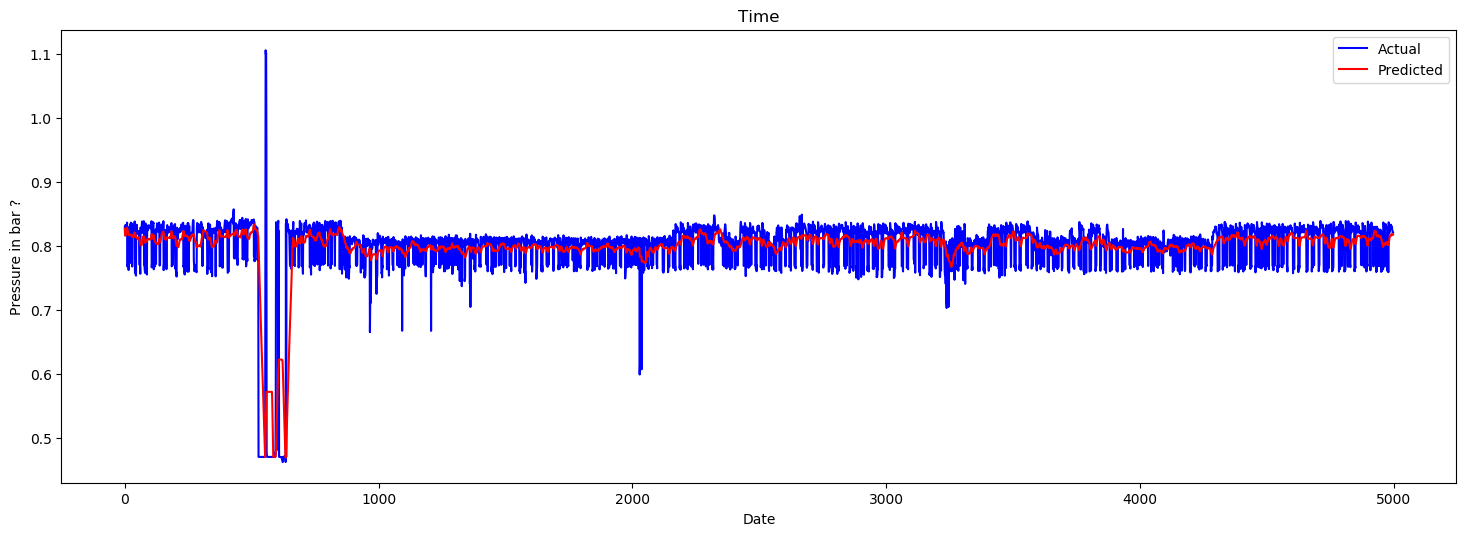

Results for window size - 27
  MSE result: 0.00152
  R2 score:   0.44292


[(1, 1.0),
 (2, 0.9211396915436909),
 (3, 0.8659391391429592),
 (4, 0.8088685593790825),
 (5, 0.7583948585940136),
 (6, 0.7137570513800736),
 (7, 0.6758167982247529),
 (8, 0.646665139457399),
 (9, 0.6222768349185055),
 (10, 0.6003571493607283),
 (11, 0.578758455671252),
 (12, 0.5614726630857467),
 (13, 0.5447720908719892),
 (14, 0.5305040895269093),
 (15, 0.5186624565773814),
 (16, 0.5085077486512437),
 (17, 0.5001970564986788),
 (18, 0.4931179630927358),
 (19, 0.4873988646537296),
 (20, 0.48284719105683904),
 (21, 0.4787495796468719),
 (22, 0.4745600577735558),
 (23, 0.47003806384783564),
 (24, 0.4642363839581233),
 (25, 0.4575628685537513),
 (26, 0.450512528543486),
 (27, 0.4429202610382985),
 (28, 0.43530877491313225),
 (29, 0.4287591653282913)]

In [19]:
data_249_main, test = generate_learn_test_for_feature()

max_r2 = -1
i_max = 0
arr = []
for i in range(1, 65):
    r2 = rolling_window(i, data_249_main, False, False)
    """if r2 > max_r2:
        max_r2 = r2
        i_max = i"""
    arr.append((i, r2))
        
# print("Max r2: ", max_r2, "Current i:", i_max)
# rolling_window(25, data_249_lag)
rolling_window(27, data_249_main)
arr[:29]

Poglej si
https://tsfresh.readthedocs.io/en/latest/text/tsfresh_on_a_cluster.html

In [ ]:
def rolling_window(window_width, data, plot=True, print_val=True):
    temps = pandas.DataFrame(data["analog2"])
    temps.columns = ["predicted-analog"]

    temps = temps.rolling(window=window_width).mean()
    # print(temps)
    dataframe = concat([temps, data], axis=1)
    dataframe = dataframe.drop(dataframe.index[[i for i in range(0, window_width - 1)]])
    # print(dataframe.head(5))
    
    y_val_predicted = dataframe["predicted-analog"].values
    y_val_actual = dataframe["analog2"].values
    shared_x = [i for i in range(len(y_val_actual))]
    
    # i need to train a regresor for learn function

    if plot:
        fig = plt.figure(figsize=(18, 6), dpi= 100, facecolor='w')
        plt.plot(shared_x, y_val_actual, color="blue", label="Actual")
        plt.plot(shared_x, y_val_predicted, color="red", label="Predicted")

        plt.ylabel('Pressure in bar ?')
        plt.xlabel('Date')
        plt.legend()
        plt.title('Time')
        plt.show()
    
    diff = mean_squared_error(y_val_actual, y_val_predicted)
    coefficient_of_dermination = r2_score(y_val_actual, y_val_predicted)
    
    if print_val:
        print("Results for window size -", window_width)
        print("  MSE result: {:0.5f}".format(diff))
        print("  R2 score:   {:0.5f}".format(coefficient_of_dermination))
        
    return coefficient_of_dermination

In [ ]:
"""shift_arr = []
dt_names = []

for i in range(0, window_width + 1):
    shift_arr.append(temps.shift(i))
    
    if i != 0:
        dt_names.append("t-"+ str(i))
    else:
        dt_names.append("analog2-t0")
    
dataframe_main = concat(shift_arr, axis=1)   
dataframe_main.columns = dt_names


print(dataframe_main)
combined = concat([data_249_lag, dataframe_main], axis=1) 
dataframe_main = dataframe_main.drop(dataframe_main.index[[i for i in range(0, 24)]])"""

"""temps = temps.shift(window_width)
window = temps.rolling(window=window_width)
means = window.mean()
dataframe = concat([temps, means], axis=1)
dataframe = dataframe.drop(dataframe.index[[i for i in range(0, 50)]])"""